## Introduction
This is a humble attempt to try and make any reader, especially one new to the fields of data science, a little more aware of how things work together. How you go from a simple data table to actually predicting something.

I simply started with a Kaggle Starter notebook for the Breast Cancer dataset and all the EDA you see in the beginning of this article was done by the Kaggle Bot. I start my own work, a little later.  

In this article, we will take the Breast Cancer dataset and learn about Support vector Machines and how to use them as we build our own prediction/classification model.

If you really want to support research towards Breast Cancer please visit https://www.breastcancer.org/ to learn more about the disease.

## Note:

Special thanks to PARTH BHARDWAJ who is the original author of this notebook.

https://www.kaggle.com/code/thewiredbear/tutorial-svm-with-breast-cancer-dataset

## Exploratory Analysis ( Thank you KaggleBot for this )
To begin this exploratory analysis, first use `matplotlib` to import libraries and define functions for plotting the data. Depending on the data, not all plots will be made. (Hey, I'm just a kerneling bot, not a Kaggle Competitions Grandmaster!)

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns


There is 1 csv file in the current version of the dataset:


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [27]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (int(nCol) + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow+1, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [3]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [4]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

### Let's check 1st file: data.csv

In [29]:
df1 = pd.read_csv('data.csv', delimiter=',')
df1.dataframeName = 'data.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 569 rows and 33 columns


Let's take a quick look at what the data looks like:

In [30]:
df1.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Distribution graphs (histogram/bar graph) of sampled columns:

Correlation matrix:

C:\Users\saif_\AppData\Local\Temp\ipykernel_16904\128494285.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


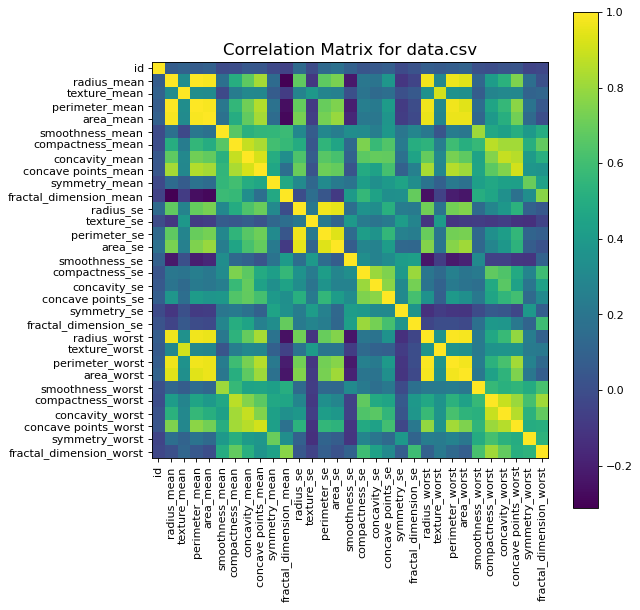

In [31]:
plotCorrelationMatrix(df1, 8)

Scatter and density plots:

C:\Users\saif_\AppData\Local\Temp\ipykernel_16904\950191735.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


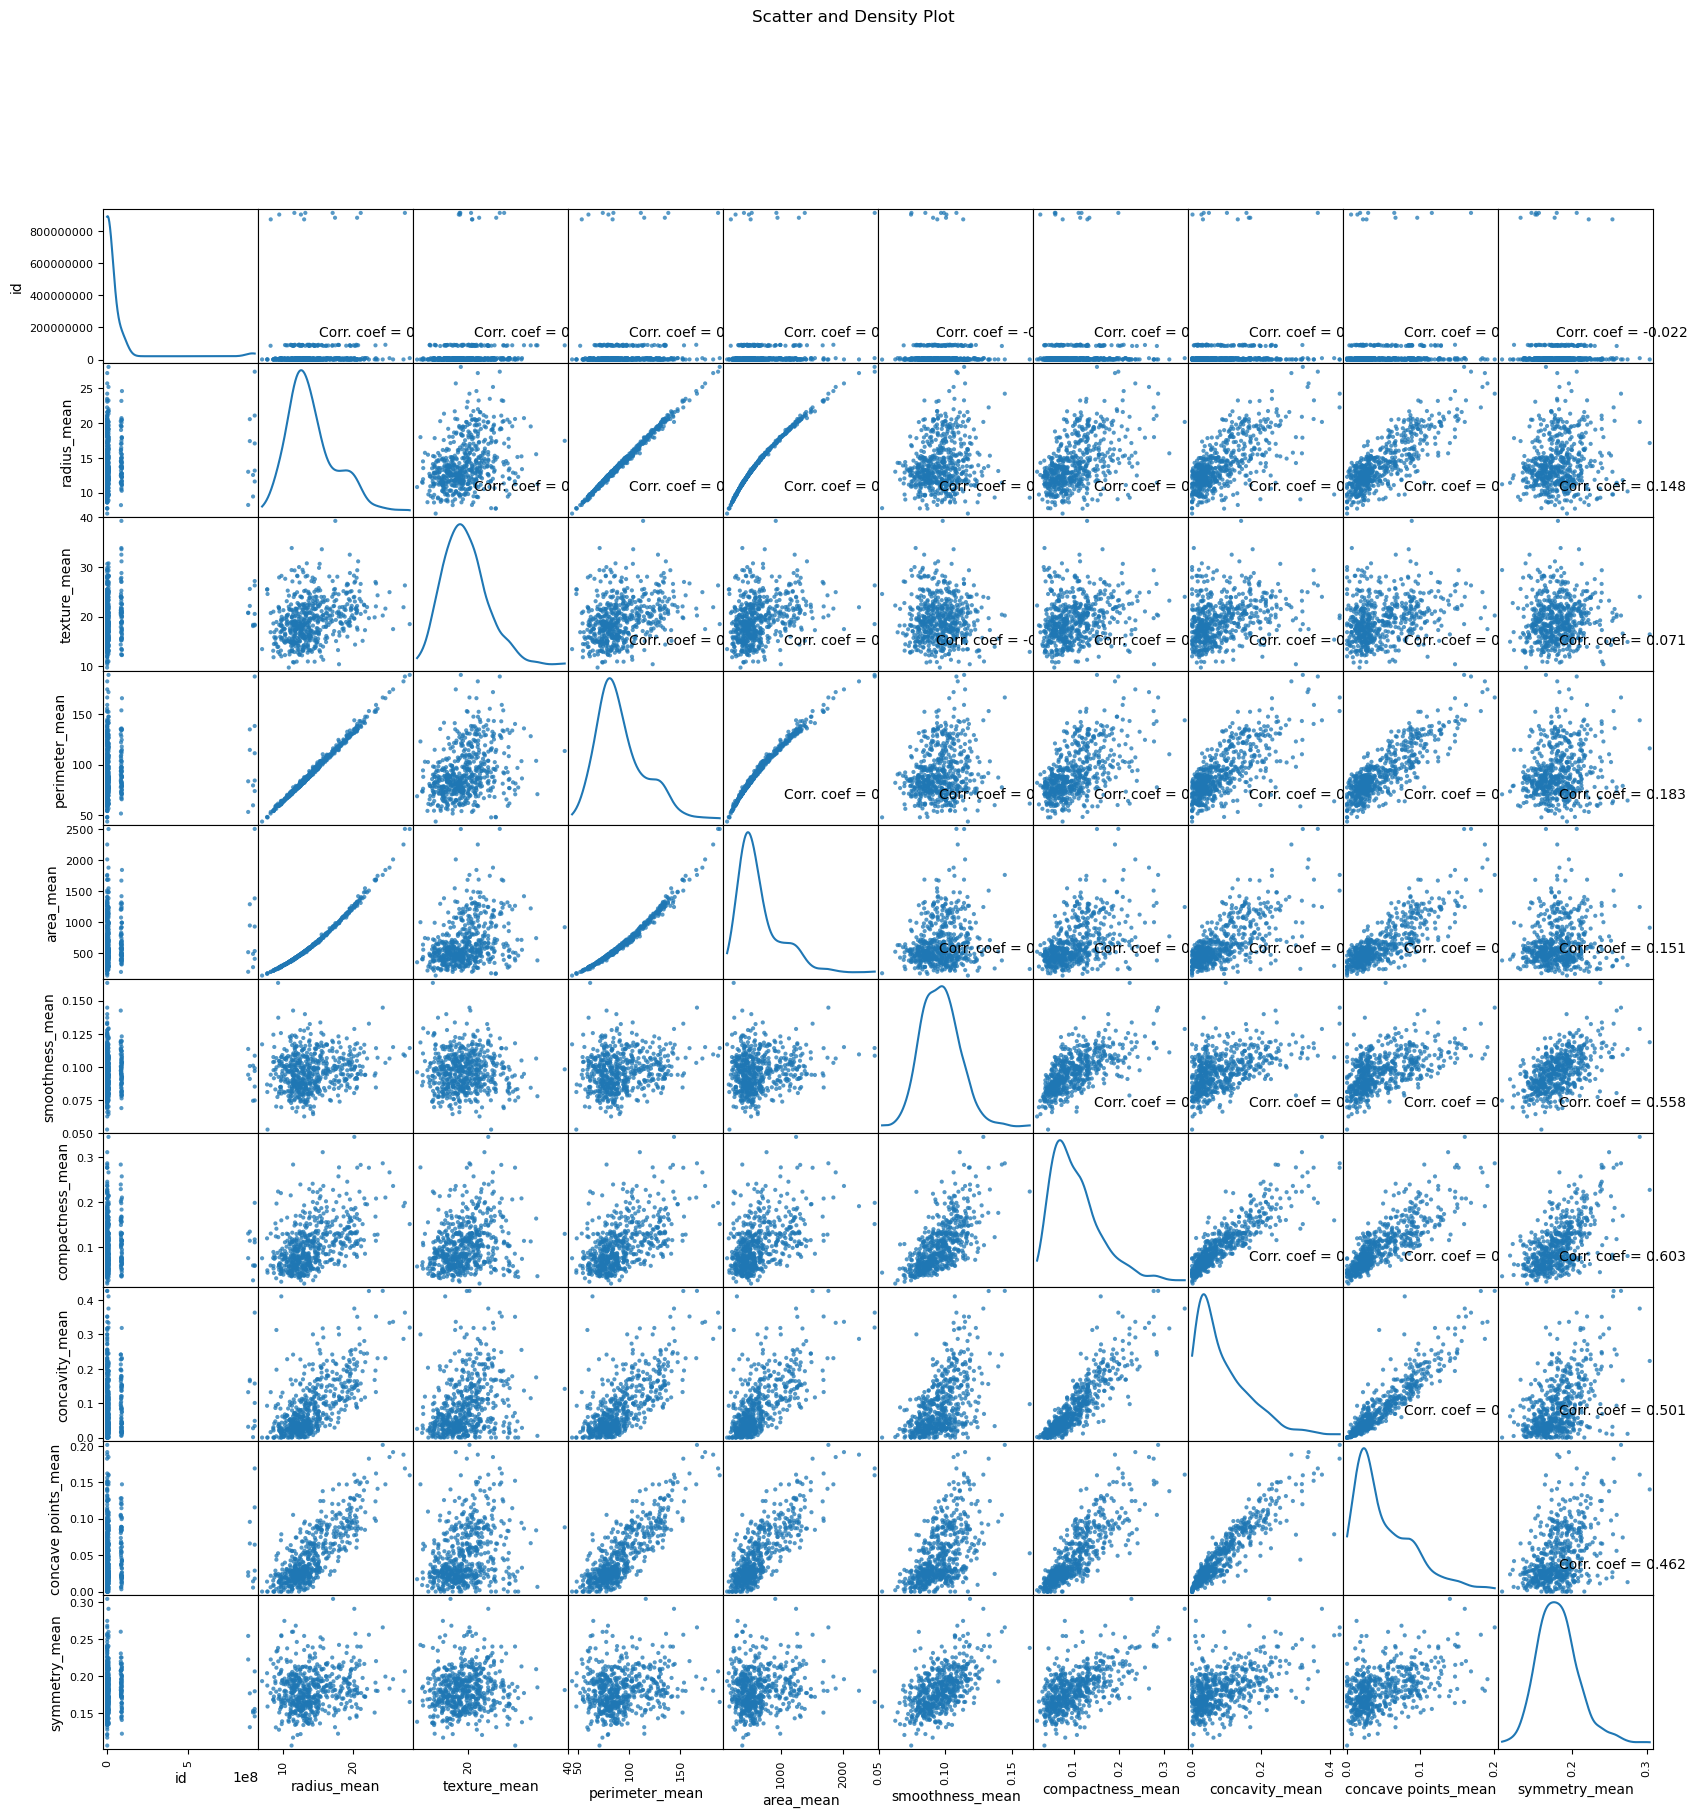

In [32]:
plotScatterMatrix(df1, 20, 10)

## Personal Work
( From this point on, we are on our own - no more KaggleBot. )

The first thing we will do is to create a pairplot - The bot has already done that for us above but it used a complex function to do so and not only that, you can't tell the malignant from benign cases in the previous visualization.
Here we will use Seaborn to create out plot and we will color it accordingly for the different cases. The agenda here is to get a 'bird-eye' view to maybe build intuition about what variables can really help us.

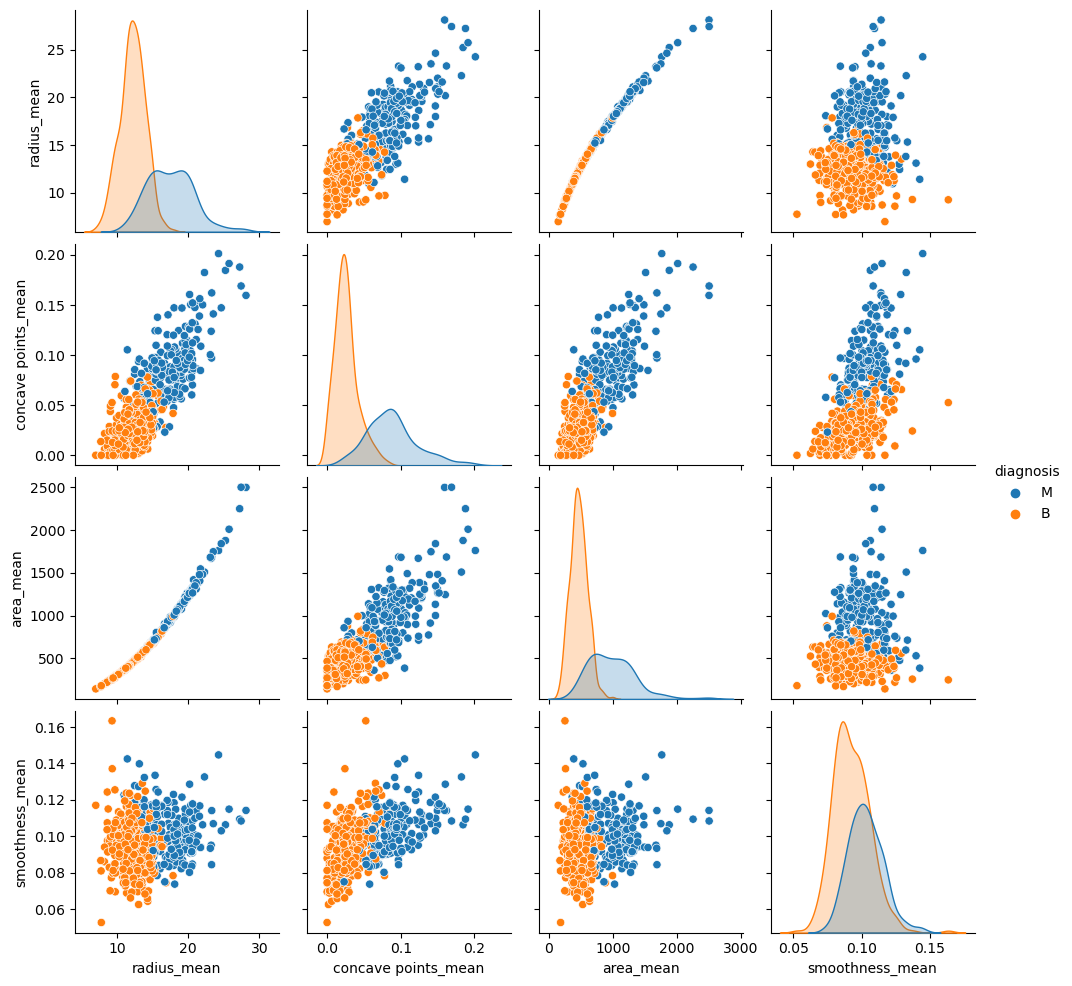

In [33]:
sns.pairplot(df1, hue='diagnosis',vars = ['radius_mean','concave points_mean','area_mean','smoothness_mean'])

Here the cases are seperated into malignant and benign cases. categorized according to the color, we can already see how some of the columns like 'area_mean' and 'concave points_mean' are good classifiers for our use case because we can 'see' a clear seperation in the two variables. It can be important here, to note why and how 'smoothness_mean' is not as good of a classifier when compared to the others. Learning to read whatever plot you create is a key Data Analysis skill.

Next in line is to figure out a base model with any which variables that we prefer. The motive to build this model is not to predict anything but just to have something to compare against the final model that we will keep. However, we are better off taking some 'educated' guesses here.

In [34]:
# The first order of business now is to create new variables which you will then feed into the model functions
# We will create training and test sets to both train our data on and then test our model as well.

X = df1.drop(['diagnosis'],axis=1)#drop the target class from train set
Y = df1['diagnosis']#seperating out the target class
print(X.columns)

Index(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


In [35]:
## Extra step to deal with null data
X = X.dropna(axis=1) # axis-1 is running horizontal across columns. axis=0 is downwards across rows
print(X.columns)
#NOTE : I was getting a 'null' error while making my model. I tried removing 'Unnamed: 32' just as I had 
# removed the 'diagnosis' column, however the error still crept up, so I used the old tried and trusted
# .dropna() function.

Index(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
#notice how the train_test_split function takes the test size and not the 
#size of the train size.Also 42 is the answer to everything.

In [37]:
#Now that our sets to train are ready, we may just choose to look at their
#new dimensions as well
print(X_train.shape)

(455, 31)


In [38]:
print(Y_train.shape)

(455,)


<AxesSubplot:>

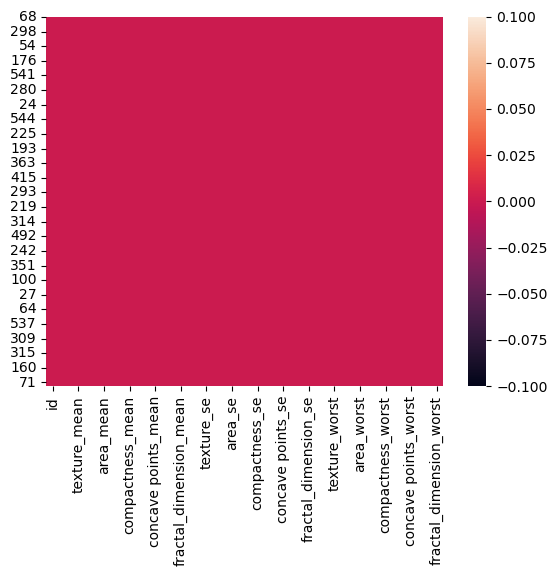

In [39]:
# I love using the sns heatmap to visualize the null values
sns.heatmap(X_train.isnull())

In [40]:
#Now to actually building the model
from sklearn.svm import SVC #from support vector machine get support vector classifier
from sklearn.metrics import classification_report, confusion_matrix #these will make sense later

svc_model = SVC() #initialize the code module
svc_model.fit(X_train,Y_train) #fit your data variables to the model

SVC()

****Evaluating our first test model****

<AxesSubplot:>

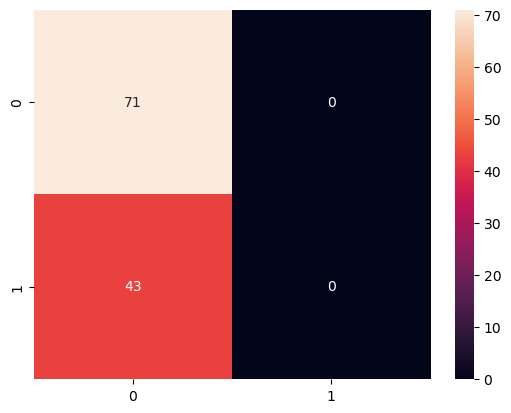

In [41]:
y_predict = svc_model.predict(X_test) # get 'y' by predict FOR the TEST values.
cm = confusion_matrix(Y_test,y_predict) # we use the confusion matrix to check
                                        #how our predicted y compares to the
                                        # real one.
sns.heatmap(cm,annot=True)

Here it is interesting to see that our first model has actually classified all points as 'benign'. From this point on, it will be beneficial to try and understand how we build our next models and how they contrast to this one.

In [42]:
print(classification_report(Y_test,y_predict))

              precision    recall  f1-score   support

           B       0.62      1.00      0.77        71
           M       0.00      0.00      0.00        43

    accuracy                           0.62       114
   macro avg       0.31      0.50      0.38       114
weighted avg       0.39      0.62      0.48       114



C:\Users\saif_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saif_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saif_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classification report only pushes further the fact that our model can NOT classify and identify malignant cases.

**Improving our model**

The 'spread' of our data is across ranges of many magnitudes. While on the one hand, we have a column with values betwwen 0.0 and 0.26, on the other hand there are columns with values ranging from 200 to 2500. Having such contrasting ranges can throw off our model's predictions.

We will use 'unity-based normalization' to solve this problem. We will essentially turn all the columns to a 0-1 range. This will allow a proper foundation for our prediction model.

https://en.m.wikipedia.org/wiki/Feature_scaling

In [43]:
min_train = X_train.min()
min_train

id                         8913.000000
radius_mean                   7.691000
texture_mean                  9.710000
perimeter_mean               47.920000
area_mean                   170.400000
smoothness_mean               0.052630
compactness_mean              0.019380
concavity_mean                0.000000
concave points_mean           0.000000
symmetry_mean                 0.116700
fractal_dimension_mean        0.049960
radius_se                     0.111500
texture_se                    0.360200
perimeter_se                  0.757000
area_se                       6.802000
smoothness_se                 0.001713
compactness_se                0.002252
concavity_se                  0.000000
concave points_se             0.000000
symmetry_se                   0.007882
fractal_dimension_se          0.000895
radius_worst                  8.678000
texture_worst                12.020000
perimeter_worst              54.490000
area_worst                  223.600000
smoothness_worst         

In [44]:
range_train = (X_train-min_train).max()
range_train

id                         9.113116e+08
radius_mean                2.041900e+01
texture_mean               2.957000e+01
perimeter_mean             1.405800e+02
area_mean                  2.330600e+03
smoothness_mean            1.107700e-01
compactness_mean           2.920200e-01
concavity_mean             4.268000e-01
concave points_mean        2.012000e-01
symmetry_mean              1.873000e-01
fractal_dimension_mean     4.748000e-02
radius_se                  2.761500e+00
texture_se                 4.524800e+00
perimeter_se               2.122300e+01
area_se                    5.353980e+02
smoothness_se              2.941700e-02
compactness_se             1.331480e-01
concavity_se               3.960000e-01
concave points_se          5.279000e-02
symmetry_se                5.357800e-02
fractal_dimension_se       2.894520e-02
radius_worst               2.736200e+01
texture_worst              3.752000e+01
perimeter_worst            1.967100e+02
area_worst                 4.030400e+03


In [45]:
X_train_scaled = (X_train-min_train)/range_train
X_train_scaled

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
68,0.000933,0.065527,0.257694,0.077323,0.034369,0.487226,0.417506,0.733365,0.217445,0.504004,...,0.059645,0.283316,0.055971,0.025084,0.523195,0.449380,1.000000,0.601375,0.524936,0.529502
181,0.000949,0.656203,0.570172,0.674207,0.489402,0.554934,0.903431,0.582709,0.743539,0.655633,...,0.657920,0.571962,0.620253,0.462832,0.529308,0.802879,0.541534,0.997595,0.499310,0.621906
63,0.000933,0.072579,0.140345,0.080239,0.038831,0.221901,0.233306,0.140300,0.108350,0.626802,...,0.048681,0.192164,0.056428,0.021462,0.184677,0.154303,0.111581,0.174811,0.338459,0.253137
248,0.097067,0.144914,0.524518,0.142908,0.075774,0.396678,0.181357,0.055740,0.080268,0.389749,...,0.130546,0.617537,0.119414,0.057587,0.534742,0.123555,0.089856,0.210859,0.363493,0.224059
60,0.000933,0.121407,0.174839,0.118296,0.060714,0.548614,0.209677,0.025398,0.064115,0.841431,...,0.085593,0.144723,0.078135,0.035977,0.382599,0.078376,0.017316,0.088625,0.392667,0.213293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.000934,0.058622,0.166723,0.077323,0.031580,0.408053,0.457914,0.201640,0.142744,0.392419,...,0.038557,0.097281,0.041025,0.015085,0.336412,0.237544,0.114537,0.164467,0.135817,0.452357
106,0.000937,0.193398,0.291512,0.193840,0.103879,0.555836,0.281899,0.165651,0.173211,0.338494,...,0.163073,0.459488,0.157694,0.073963,0.663112,0.262143,0.229473,0.418557,0.244628,0.304595
270,0.009768,0.323179,0.240446,0.301465,0.198318,0.105263,0.025238,0.016987,0.031064,0.182061,...,0.227761,0.230011,0.203091,0.114381,0.098485,0.025335,0.030879,0.114536,0.176030,0.052221
435,0.000987,0.307997,0.335137,0.307298,0.184116,0.481809,0.321622,0.263824,0.321223,0.268019,...,0.305606,0.500533,0.302018,0.160207,0.612171,0.361856,0.325000,0.627835,0.318155,0.427772


Let's now visualize some of our new columns and compare with our previous X_train(without scaling)

<AxesSubplot:xlabel='area_mean', ylabel='smoothness_mean'>

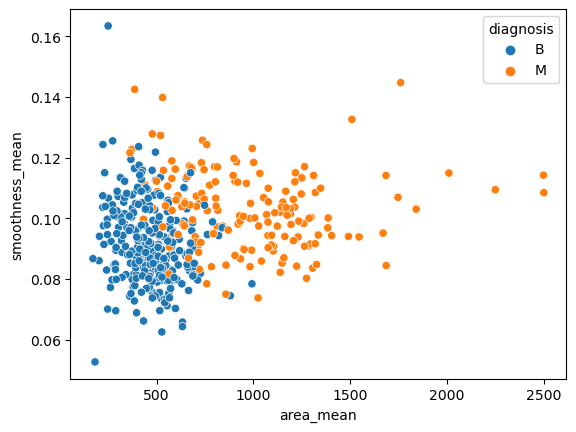

In [46]:
#without scaling
sns.scatterplot(x=X_train['area_mean'],y=X_train['smoothness_mean'],hue=Y_train)

<AxesSubplot:xlabel='area_mean', ylabel='smoothness_mean'>

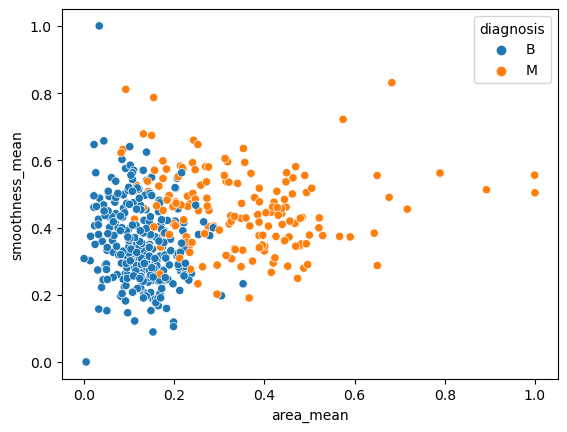

In [47]:
#with scaling
sns.scatterplot(x=X_train_scaled['area_mean'],y=X_train_scaled['smoothness_mean'],hue=Y_train)

In [48]:
#Now we need to do the same normalization for our TEST set
min_test = X_test.min()
range_test = (X_test-min_test).max()
X_test_scaled = (X_test-min_test)/range_test

In [49]:
#setting up our new SVC model
svc_model = SVC()
svc_model.fit(X_train_scaled,Y_train)

SVC()

<AxesSubplot:>

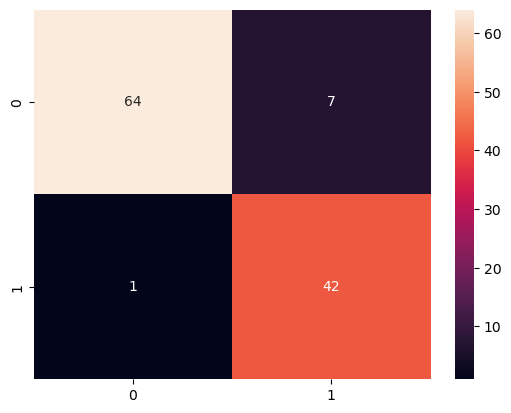

In [50]:
y_predict = svc_model.predict(X_test_scaled)
cm = confusion_matrix(Y_test,y_predict)
sns.heatmap(cm,annot=True,fmt='d')

Just with the simple improvement of our scaled features, our model has gotten better my many magnitudes. While before we had completely mis-classified all the malignant cases. Now, our model has only mis-classified a total of two cases. Let's also print the classification report for this new model ( we will get a number for this model's precision ).

In [51]:
print(classification_report(Y_test,y_predict))
# we get a 99% precision already.

              precision    recall  f1-score   support

           B       0.98      0.90      0.94        71
           M       0.86      0.98      0.91        43

    accuracy                           0.93       114
   macro avg       0.92      0.94      0.93       114
weighted avg       0.94      0.93      0.93       114



**Improving our model, this time with hyperparameters.**

All machine learning modules packaged as Python libraries, have their unique set of hyperparameters. These 'parameters' are the gateway to fine tuning our models. The two such variables which concern us here are 'c' and 'gamma'.  

Even though our model might already seem very strong, it is a good exercise to work with these fine tuning variables as well.

**Refresher**  
'c' - this is a measure of how much you want the model to penalize a wrong classification. A higher value of 'c' can lead to over training.  
'gamma' - Sometimes it is fruitful to add weight to our data points. A higher gamma value will give a heavier 'weight' to points bunched closely together and also reduce the weightage to outlier points.

Needless to say, it can be a tedious task trying to manually figure out a perfect combination of these variables. At this point, you can rest assure there is a python library/function to do everything and here we will use GridSearchCV to figure out the best set of hyperparameters for us.

In [52]:
param_grid = {'C':[0.1,1,10,100],'gamma':[0.1,1,0.01,0.001],'kernel':['rbf']}
from sklearn.model_selection import GridSearchCV #read GridSearchCrossValidation
grid = GridSearchCV(SVC(),param_grid,)

Kernel Selection is a rather important skill which comes in handy for many different kinds of classification models, especially Support Vector Machines.
https://www.kdnuggets.com/2016/06/select-support-vector-machine-kernels.html  
This is a great article, a quick 5 minute read to clarify how and why different kernels exist and how to pick one for yourself. We could add all kernels to the GridSearch function but that would be excessive and unnecessary computing power and time.  

Reading through documentation to learn what different parameters represent is both very energy draining and also a very crucial part of the job. Here we use refit and verbose parameters with GridSearchCV. Here are two links for the same:  
https://stackoverflow.com/questions/26962050/confused-with-repect-to-working-of-gridsearchcv  
https://stackoverflow.com/questions/24121018/sklearn-gridsearch-how-to-print-out-progress-during-the-execution   
Lesson learned : Documentation is not always super lear, get used to experimenting with such things to get a better feel of what they are about. Doing data science is the best way to learn data science.

In [53]:
grid.fit(X_train_scaled,Y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 0.01, 0.001],
                         'kernel': ['rbf']})

In [54]:
grid.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [55]:
grid.best_estimator_

SVC(C=1, gamma=1)

In [56]:
grid_predictions = grid.predict(X_test_scaled)

<AxesSubplot:>

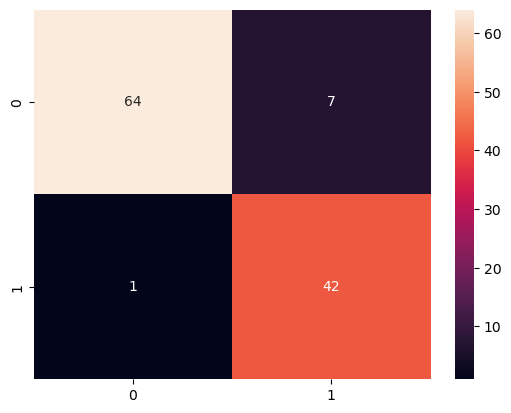

In [57]:
cm = confusion_matrix(Y_test,grid_predictions)
sns.heatmap(cm,annot=True)

In [58]:
print(classification_report(Y_test,grid_predictions))

              precision    recall  f1-score   support

           B       0.98      0.90      0.94        71
           M       0.86      0.98      0.91        43

    accuracy                           0.93       114
   macro avg       0.92      0.94      0.93       114
weighted avg       0.94      0.93      0.93       114



## The naked truth

As it is very nicely visible, we lost prediction power in our model.  
Lesson learned - 'Life is not all sunshine and rainbows'

The takeaway at this point is that our model can do the required task of properly classifying breast cancer cases. However if we do want to create a very fine tuned model to do our job, just to be sure, we need a lot more data. Not only that, we need a lot more experimentation time as well. We can see that our previous model where gamma was 'auto_deprecated' performed better than having a set gamma value. Even if we do decide to stick with our simpler model, we can be never sure of how it holds against a bigger dataset.

Making predictions and taking decisions upon them, has been,is and shall always be a dirty task. LOL

Happy Data Hacking!!

## Conclusion
I started writing this kernel with the goal of creating something, I never had. Someone to tell me, how it all ties together.  

'DOING' data science is very different from simply learning it, rather I might say that if you haven't DONE data science, you never really learned it.
I hope I was able to clear somethings for the new people, I hope the old people read this and help me iron out my own mistakes.

We are all in this together!! I'll be more than happy to start a long conversation in the comments :D